# Alias Sampling

<div class="alert alert-block alert-info admonition note"> <p class="admonition-title"><b>NOTE:</b></p>

This tutorial, as well as all the other tutorials, has been written as a jupyter notebook.
If you're reading it online, you can either keep reading, or clone the repository and go to `docs/tutorials` to explore them in a more interactive way!

</div>

The example we used in previous tutorial was nice to establish some basic terminology. But let's be honest, it was contrived and not very practical. So now we'll take an existing example from a paper and try to get some resource estimations for it using `bartiq`!

For that we'll use Alias Sampling—an algorithm proposed by Babbush et al. in [Encoding Electronic Spectra in Quantum Circuits with Linear T Complexity](https://journals.aps.org/prx/abstract/10.1103/PhysRevX.8.041015). This is what the circuit looks like:

![Alias Sampling](../images/alias_sampling_paper.png)


It comes from Fig. 11 from the original paper.

This circuit is an important subroutine in the paper's larger algorithm because it is responsible for preparing arbitrary quantum states, which can be thought of as "loading" data into the quantum computer.

In this tutorial we won't be explaining how the algorithm works in details—partly because this is not the place, and partly because [Craig Gidney already did it in his blogpost](https://algassert.com/post/1805)

But briefly and at a high level, Alias Sampling contains the following subroutines:
- $\textrm{UNIFORM}_L$: prepares a state which is a uniform superposition over $L$ basis states
- $H^{\otimes\mu}$: applies a set of Hadamard gates to create a uniform superposition over $2^{\mu}$ basis states
- QROM: loads data values into two "data" registers in superposition depending on the state input to $\textrm{In}_{\ell}$
- Comparator: flips a target qubit if $\textrm{keep}_l \leq \sigma_l$ based on the values of the two other input registers (to $\textrm{In}_{\sigma_l}$ and $\textrm{In}_{\textrm{keep}_l}$ respectively).
- Controlled SWAP: swaps two target registers conditional on the value of a control qubit.

Now, before we map all these subroutines to `bartiq`, it would be good to know what the costs of each of the subroutines are. After carefully reading the paper we can deduce what the costs are. But before we get there, let's define our symbols to have consistent naming.  The authors use same letters for different variables in different figures, so it can get confusing without reading the paper carefully—that's why we'll stick to the naming from the figure above to keep things simple.

- $L$ – number of coefficients we want to load.
- $\mu$ – bits of precision for coefficients we load.
- $k$ is the greatest common factor of $L$. This is not a widely-used mathematical operation, but fortunately in `bartiq` we have a shorthand for that, and we can say that `k = multiplicity(2, L)`. For more information, you can check how [it's defined in sympy](https://docs.sympy.org/latest/modules/ntheory.html#sympy.ntheory.factor_.multiplicity).

Given all that—what are the costs of our routines? For the purpose of we shall focus on just calculating the T-gate and rotation costs: 

- Uniform: $8\log_2(L/k)$ T-gates and 2 rotation gates. It comes Fig 12 and its caption. We omit the $O(\log(1/\epsilon)$ term, because it corresponds to those two rotations that we count separately.
- Hadamards: No T-gates or rotations.
- QROM: $4L-4$ – this comes from Fig. 10.
- Comparator: $4\mu-4$ – this is not stated explicitly in the text, but comes from a careful analysis of the caption of Fig. 11.
- Swap: $O(\log_2(L))$ – this is not stated explicitly in the text, but comes from a careful analysis of the caption of Fig. 11.

These expressions don't take into account some nuances—for example the uniform state preparation (USP) can be implemented as a layer of Hadamard gates if $L$ is a power of two.

Armed with this knowledge, we can now write each individual routine.
However, since in this case all the routines have similar structure, we can use the following helper function:

<div class="alert alert-block alert-info admonition note"> <p class="admonition-title"><b>NOTE:</b></p>

Unfortunately the costs presented in this example are quite complicated. It would be great to just point you to a single place in the paper, get an expression and type it into `bartiq`. That's not the case though and if there are any mistakes or oversimplifications—please let us know! However, the fact that even a relatively simple routine presents such challenges, shows that we need better tools for working with quantum algorithms.

Also, as it turns out in the follow-up work not all the costs from this paper are correct, as some routines can be optimized. But explaining that is way beyond the scope of this tutorial.

</div>

In [1]:
usp_dict = {
    "name": "usp",
    "type": None,
    "ports": [
        {"name": "in", "direction": "input", "size": "R"},
        {"name": "out", "direction": "output", "size": "R"},
    ],
    "resources": [
        {"name": "T_gates", "type": "additive", "value": "8*L/multiplicity(2,L)"},
        {"name": "rotations", "type": "additive", "value": "2"},
    ],
    "input_params": ["L"],
    "local_variables": {"R": "ceiling(log_2(L))"},
}

There are two things that we did here which might not be straight-forward.

- We used `ceiling` function for the port size—that's because port sizes need to be integer.
- We introduced new field: `local_variables`. This allows us to define some "helper" variables, which are only used in the scope of this routine and save us some typing

In [2]:
had_dict = {
    "name": "had",
    "type": None,
    "ports": [
        {"name": "in", "direction": "input", "size": "N"},
        {"name": "out", "direction": "output", "size": "N"},
    ],
}

In [3]:
qrom_dict = {
    "name": "qrom",
    "type": None,
    "ports": [
        {"name": "In_l", "direction": "input", "size": "R"},
        {"name": "In_alt", "direction": "input", "size": "R"},
        {"name": "In_keep", "direction": "input", "size": "mu"},
        {"name": "out_l", "direction": "output", "size": "R"},
        {"name": "out_alt", "direction": "output", "size": "R"},
        {"name": "out_keep", "direction": "output", "size": "mu"},
    ],
    "resources": [{"name": "T_gates", "type": "additive", "value": "4*L-4"}],
    "input_params": ["L", "mu"],
    "local_variables": {"R": "ceiling(log_2(L))"},
}

In [4]:
compare_dict = {
    "name": "compare",
    "type": None,
    "ports": [
        {"name": "In_sigma", "direction": "input", "size": "mu"},
        {"name": "In_keep", "direction": "input", "size": "mu"},
        {"name": "In_flag", "direction": "input", "size": "1"},
        {"name": "out_sigma", "direction": "output", "size": "mu"},
        {"name": "out_keep", "direction": "output", "size": "mu"},
        {"name": "out_flag", "direction": "output", "size": "1"},
    ],
    "resources": [{"name": "T_gates", "type": "additive", "value": "4*mu-4"}],
    "input_params": ["mu"],
}

In [5]:
swap_dict = {
    "name": "swap",
    "type": None,
    "ports": [
        {"name": "In_control", "direction": "input", "size": "1"},
        {"name": "In_target_0", "direction": "input", "size": "X"},
        {"name": "In_target_1", "direction": "input", "size": "X"},
        {"name": "out_control", "direction": "output", "size": None},
        {"name": "out_target_0", "direction": "output", "size": None},
        {"name": "out_target_1", "direction": "output", "size": None},
    ],
    "resources": [{"name": "T_gates", "type": "additive", "value": "O(log_2(X))"}],
    "connections": [
        {"source": "In_control", "target": "out_control"},
        {"source": "In_target_0", "target": "out_target_0"},
        {"source": "In_target_1", "target": "out_target_1"},
    ],
    "input_params": ["X"],
}

We follow the same naming convention in all the subroutines to make things easier to follow. But in swap, we decided to use `X` instead of `R=ceil(log_2(L))`. Why? 

It shows, that we can use whatever naming we want for any particular subroutine – we don't need to stick to one convention in all the subroutines. This is what you would often want to do in practice. If you would like to reuse this controlled swap in some other algorithm, a generic `X` is a much better choice than a very specific `R`.

Now that we have all these defined, let's construct the dictionary for the whole algorithm:

In [6]:
alias_sampling_dict = {
    "name": "alias_sampling",
    "children": [usp_dict, had_dict, qrom_dict, compare_dict, swap_dict],
    "type": None,
    "ports": [
        {"name": "In_0", "direction": "input", "size": "R"},
        {"name": "In_1", "direction": "input", "size": "mu"},
        {"name": "In_2", "direction": "input", "size": "R"},
        {"name": "In_3", "direction": "input", "size": "mu"},
        {"name": "In_4", "direction": "input", "size": "1"},
        {"name": "out_0", "direction": "output", "size": None},
        {"name": "temp_0", "direction": "output", "size": None},
        {"name": "temp_1", "direction": "output", "size": None},
        {"name": "temp_2", "direction": "output", "size": None},
        {"name": "temp_3", "direction": "output", "size": None},
    ],
    "connections": [
        {"source": "In_0", "target": "usp.in"},
        {"source": "In_1", "target": "had.in"},
        {"source": "In_2", "target": "qrom.In_alt"},
        {"source": "In_3", "target": "qrom.In_keep"},
        {"source": "In_4", "target": "compare.In_flag"},
        {"source": "usp.out", "target": "qrom.In_l"},
        {"source": "had.out", "target": "compare.In_sigma"},
        {"source": "qrom.out_l", "target": "swap.In_target_0"},
        {"source": "qrom.out_alt", "target": "swap.In_target_1"},
        {"source": "qrom.out_keep", "target": "compare.In_keep"},
        {"source": "compare.out_flag", "target": "swap.In_control"},
        {"source": "swap.out_target_0", "target": "out_0"},
        {"source": "compare.out_sigma", "target": "temp_0"},
        {"source": "swap.out_target_1", "target": "temp_1"},
        {"source": "compare.out_keep", "target": "temp_2"},
        {"source": "swap.out_control", "target": "temp_3"},
    ],
    "input_params": ["mu", "L"],
    "local_variables": {"R": "ceiling(log_2(L))"},
    "linked_params": [
        {"source": "L", "targets": ["usp.L", "qrom.L", "swap.X"]},
        {"source": "mu", "targets": ["qrom.mu", "compare.mu"]},
    ],
}

In [7]:
alias_sampling_qref = {"version": "v1", "program": alias_sampling_dict}

Additionally, you can examine how the circuit is represented in `qref` format by visualizing it. 

<div class="alert alert-block alert-info admonition note">
    <p class="admonition-title"><b>NOTE:</b></p>
    <p>
        To use the <a href="https://github.com/PsiQ/qref">qref</a> rendering tool in Jupyter Notebook, ensure the Graphviz software is installed on your OS and that its executables are included in your system variables. For installation instructions, please refer to the <a href="https://graphviz.org/download/">Graphviz download page</a>.
    </p>
</div>

<p>Once installed, proceed to visualize the representation of the circuit.</p>

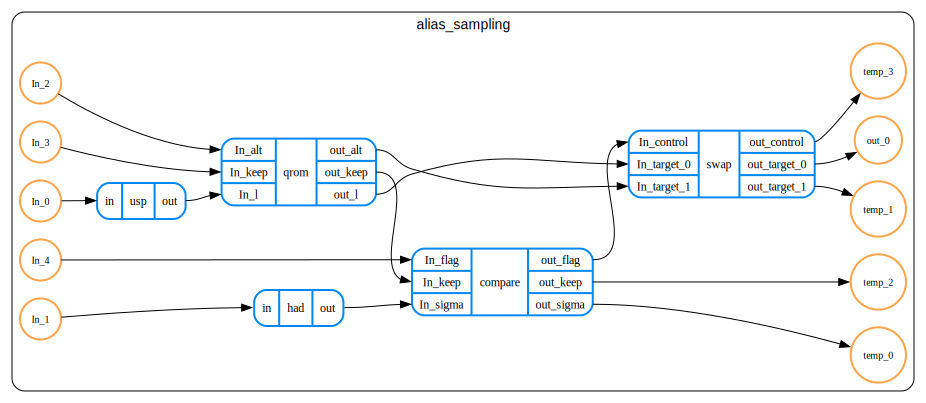

In [8]:
from qref.experimental.rendering import to_graphviz

# Convert the qref format to Graphviz object
gv_object = to_graphviz(alias_sampling_qref)

# Render the Graphviz object to a PNG file
gv_object.render("alias_sampling", format="png")
gv_object

As we expected, the diagram displays five subroutines which are `usp`, `qrom`, `compare`, `had`, `swap`, and their hierarchical connections. Everything appears to be in order! Let's proceed with the compilation.


In [9]:
from bartiq.integrations import qref_to_bartiq

uncompiled_routine = qref_to_bartiq(alias_sampling_qref)

In [10]:
from bartiq import compile_routine

compiled_routine = compile_routine(uncompiled_routine)

/Users/kjalowiecki/Projects/bartiq/src/bartiq/compilation/_compile.py:117: UserWarning: Found the following issues with the provided routine after the compilation has finished: ["Symbol P_2 found in subroutine: alias_sampling.swap.passthrough_2, which is not among top level params: {'L', 'R', 'mu'}.", "Symbol P_1 found in subroutine: alias_sampling.swap.passthrough_1, which is not among top level params: {'L', 'R', 'mu'}.", "Symbol P_2 found in subroutine: alias_sampling.swap, which is not among top level params: {'L', 'R', 'mu'}."]
  warnings.warn(


It went pretty well, let's see what's the we got:

In [11]:
for resource in compiled_routine.resources.values():
    print(f"{resource.name}: {resource.value}")

T_gates: 4*L + 8*L/multiplicity(2, L) + 4*mu + swap.O(log2(L)) - 8
rotations: 2


In the caption of Fig. 11 we had: $4(L + \mu) + O(\log_2(L))$, and these two expressions actually match pretty well.

- We have the $4(L + \mu)$ in both versions. 
- We have a `swap.O(log_2(L))` which corresponds to `O(log_2(L))`
- The `8*L/multiplicity(2, L)` term is also `O(log_2(L))`
- Constant factor of `-8` can also be incorporated in `O(log_2(L))`



Let's see how it looks like for some concrete values:

In [12]:
from bartiq import evaluate

assignments = {"L=120", "mu=8"}
evaluated_routine = evaluate(compiled_routine, assignments)
for resource in evaluated_routine.resources.values():
    print(f"{resource.name}: {resource.value}")

T_gates: swap.O(log2(120)) + 824
rotations: 2


Well, we're almost there...
There's still `swap.O()` in our expression – what is it?

This is good opportunity to talk about how to substitute arbitrary functions in `bartiq`!

As you can see, the functions in `bartiq` are namespaced by default – that's why why we have `swap.O` rather than `O`. Alternatively, you can compile your routine with `global_functions` keyword. That will remove the `swap.` namespace.

In [13]:
compiled_routine = compile_routine(uncompiled_routine, global_functions=["O"])
for resource in compiled_routine.resources.values():
    print(f"{resource.name}: {resource.value}")

T_gates: 4*L + 8*L/multiplicity(2, L) + 4*mu + O(log2(L)) - 8
rotations: 2


We still have big O there, but at least now we got rid of the `swap`. So let's assume the simplest case, i.e.`O(x) = ceiling(x)` 

In [14]:
import math


def big_O(x):
    return math.ceil(x)


functions_map = {"O": big_O}
evaluated_routine = evaluate(compiled_routine, assignments, functions_map=functions_map)
for resource in evaluated_routine.resources.values():
    print(f"{resource.name}: {resource.value}")

T_gates: 831
rotations: 2


And now we finally have some concrete numbers!

## Exploring the estimates

If we just interact with bare python objects, getting a quick idea of the values of various fields might be a bit cumbersome.
That's where `explore_routine` functions might be helpful. Try it out using the snippet below.


<div class="alert alert-block alert-info admonition note"> <p class="admonition-title"><b>NOTE:</b></p>
This is an interactive feature and will not render in the static version of the docs. To use it you need to run this tutorial as a jupyter notebook. <br>
Remember to install bartiq with <code>pip install bartiq[jupyter]</code> to make sure you have all the dependencies needed for these widgets to work (for more details visit <a href="https://psiq.github.io/bartiq/latest/installation/">installation docs</a>).
</div>


In [15]:
from bartiq.integrations import explore_routine

explore_routine(evaluated_routine)

If you'd prefer a static representation, you can also simply export routine to latex:

In [16]:
from bartiq.integrations import routine_to_latex
from IPython.display import Math

Math(routine_to_latex(evaluated_routine))

<IPython.core.display.Math object>

## Summary
Let's sum up what we covered in this tutorial:

- How to take an algorithm from a paper and compile it into `bartiq`
- How to create a routine with multiple resources, `local_variables` and custom functions
- How to use `explore_routine` and latex integration to get most out of `bartiq`